      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 colu

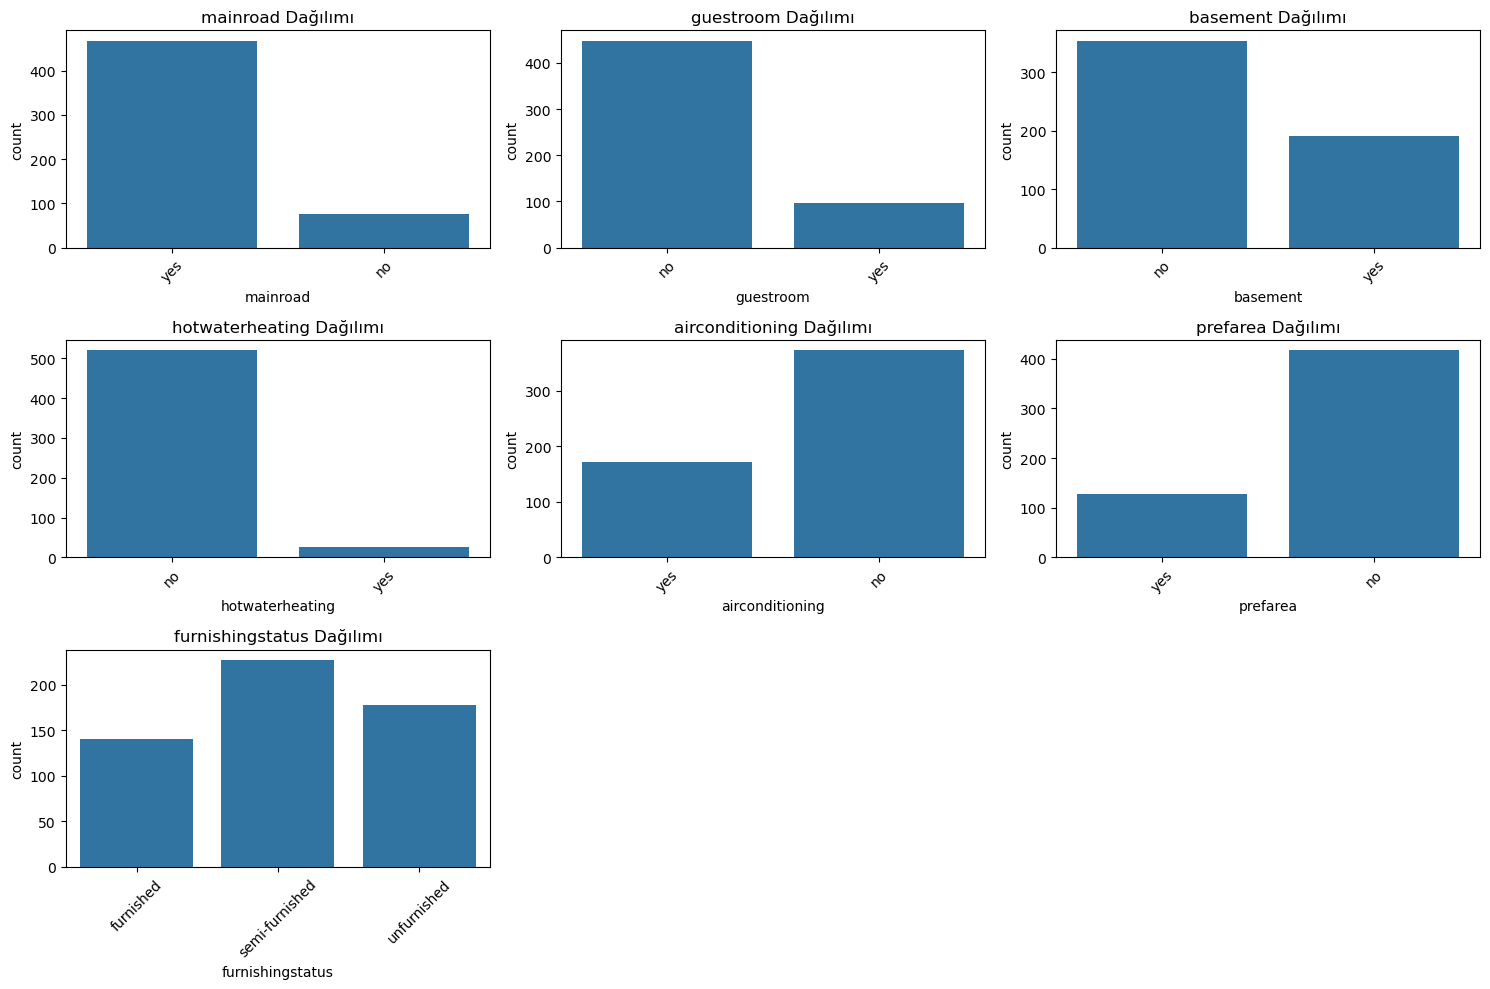

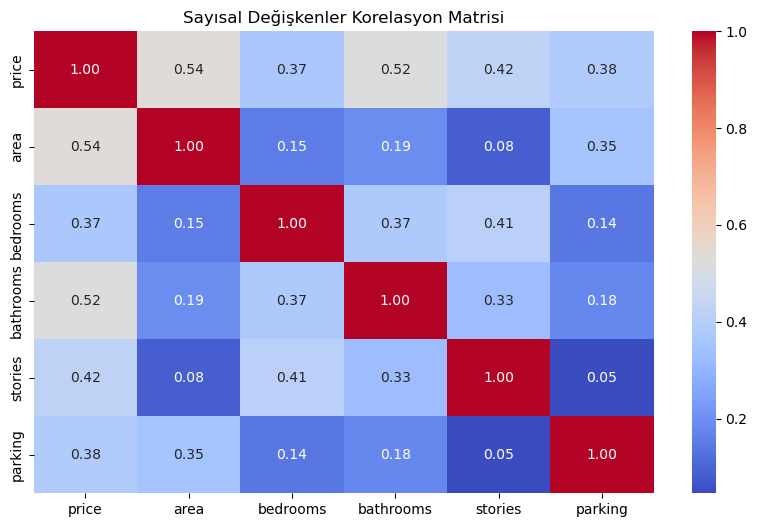

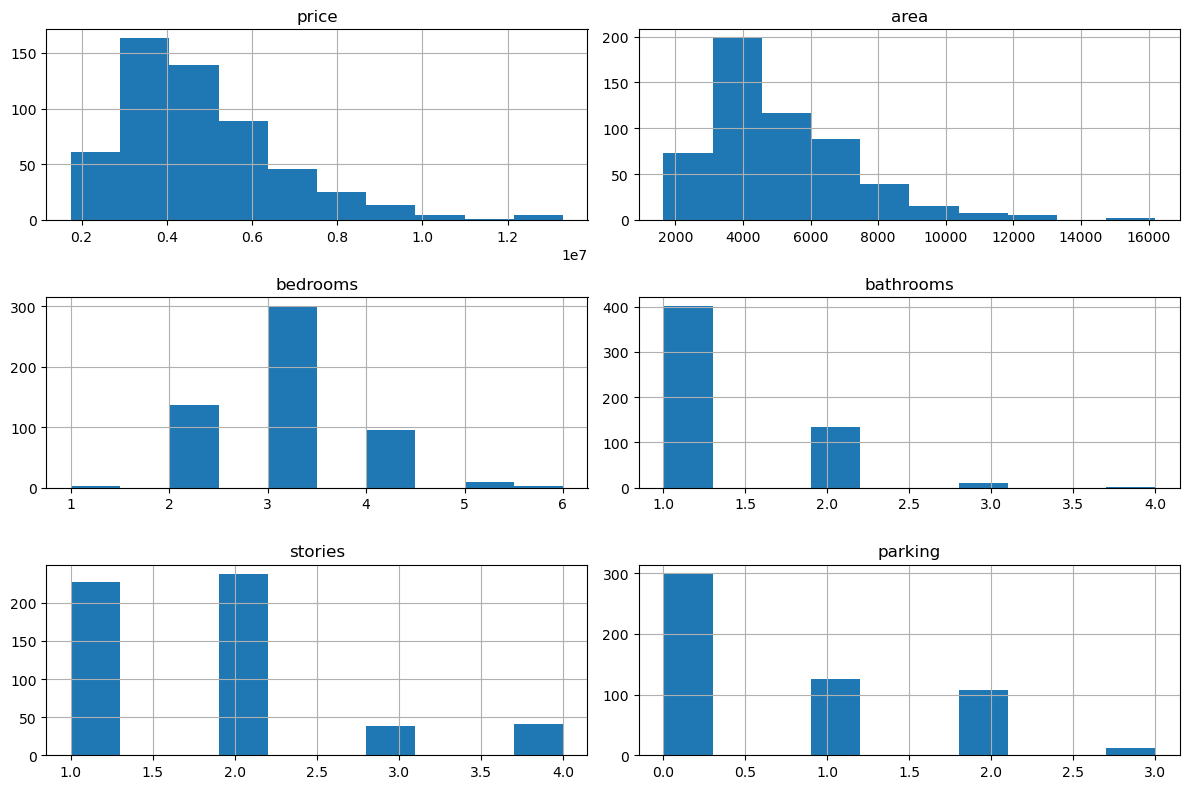

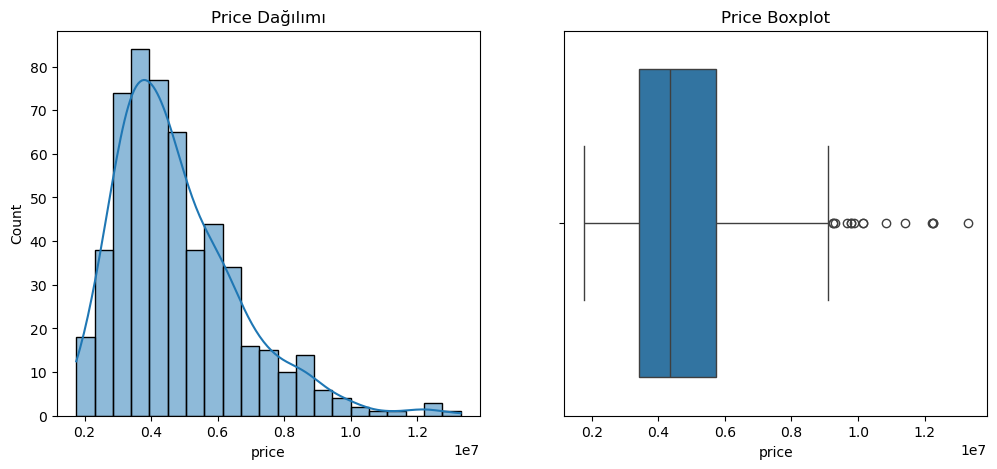

Orijinal satır sayısı: 545
Aykırı değerler çıkarıldıktan sonraki satır sayısı: 530
5-Kat (train-CV) R² skorları: [0.56912191 0.62447814 0.71594248 0.6273029  0.51313787]
Ortalama (train-CV) R²: 0.609996660518692

TEST → MAE:  865,192
TEST → MSE:  1,258,871,329,337
TEST → RMSE: 1,121,994
TEST → R²:   0.6364


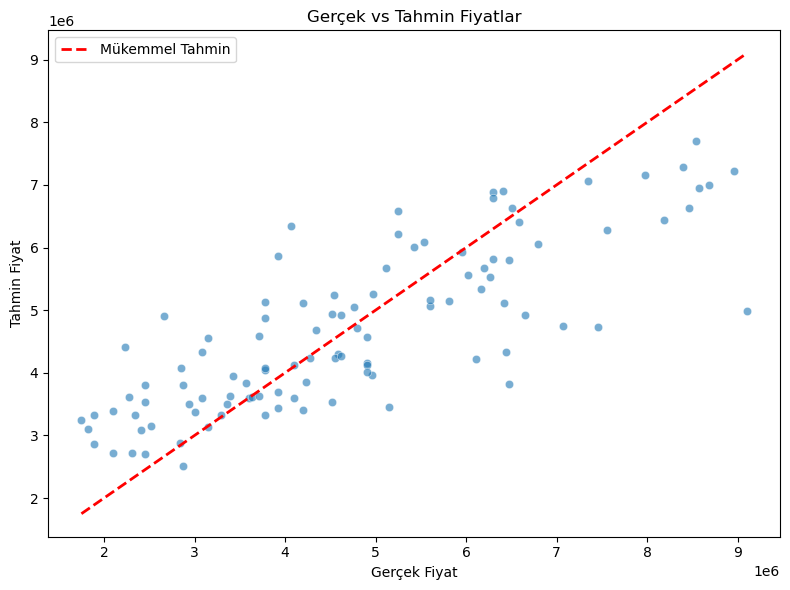

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



# 1) Veriyi yükle
df = pd.read_excel('/Users/deniz/Documents/data/Housing.xlsx')
print(df.head())



# 2) EDA + outlier
# Genel veri bilgisi ve temel istatistikler
print(df.info())
print(df.describe().T)

# Kategorik değişkenlerin bar grafikleri
cat_cols = df.select_dtypes(include='object').columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=df, x=col)
    plt.title(f"{col} Dağılımı")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Korelasyon matrisi
num_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[num_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Sayısal Değişkenler Korelasyon Matrisi")
plt.show()

# Sayısal sütunların histogramları
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols].hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

# Hedef değişkenin histogram + boxplot görselleştirmesi
plt.figure(figsize=(12, 5))
# Histogram + KDE;
plt.subplot(1, 2, 1)
sns.histplot(df['price'], kde=True)
plt.title("Price Dağılımı")
# Boxplot;
plt.subplot(1, 2, 2)
sns.boxplot(x=df['price'])
plt.title("Price Boxplot")
plt.show()

# IQR yöntemiyle 'price' sütunundaki outlier sayısı
print(f"Orijinal satır sayısı: {len(df)}")
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_clean = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)].copy()
df = df_clean.copy()
print(f"Aykırı değerler çıkarıldıktan sonraki satır sayısı: {len(df)}")



# 3) Feature Engineering
df['total_rooms']   = df['bedrooms'] + df['bathrooms']
df['area_bed_bath'] = df['area'] * df['bedrooms'] * df['bathrooms']



# 4) Özellik ve hedef ayır
X = df.drop('price', axis=1)
y = df['price']



# 5) Kategorik sütunları tespit et
cat_feats = X.select_dtypes(include='object').columns.tolist()



# 6) Ön işleyici + Pipeline 
ohe = OneHotEncoder(handle_unknown='ignore', drop=None, sparse_output=False)
pre = ColumnTransformer([('cat', ohe, cat_feats)], remainder='passthrough')
pipeline = Pipeline([('pre', pre), ('rf', RandomForestRegressor(n_estimators=100, random_state=42))])


# 7) Eğitim/Test bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# 8) Cross‑Validation (CV)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
print("5-Kat (train-CV) R² skorları:", cv_scores)
print("Ortalama (train-CV) R²:", cv_scores.mean())



# 9) Eğitim ve değerlendirme
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2   = r2_score(y_test, y_pred)

print(f"\nTEST → MAE:  {mae:,.0f}")
print(f"TEST → MSE:  {mse:,.0f}")
print(f"TEST → RMSE: {rmse:,.0f}")
print(f"TEST → R²:   {r2:.4f}")



# 10. Görselleştirme: Gerçek vs Tahmin
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2, label='Mükemmel Tahmin')
plt.title('Gerçek vs Tahmin Fiyatlar')
plt.xlabel('Gerçek Fiyat')
plt.ylabel('Tahmin Fiyat')
plt.legend()
plt.tight_layout()
plt.show()